In [15]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [16]:
from plot import plot_bar_horizontal,plot_bar_vertical,vertical_boxplot,horizontal_boxplot,create_MAD_comparison_boxplot,create_MAD_comparison_violinplot
from read_data import apply_index_file

In [17]:
np.random.seed(42)
DATASET = "../../raw_data/massive.parquet"

In [18]:
df =pd.read_parquet(DATASET)

In [19]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    
    # Convert to numpy array if it's not already
    if isinstance(series, pd.Series):
        data = series.values
    else:
        data = np.asarray(series)
    
    # Calculate the median
    median_value = np.median(data)
    
    # Calculate the absolute deviations from the median
    abs_deviations = np.abs(data - median_value)
    
    # Calculate the median of the absolute deviations
    mad = np.median(abs_deviations)
    
    return mad

In [29]:
testing = df.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

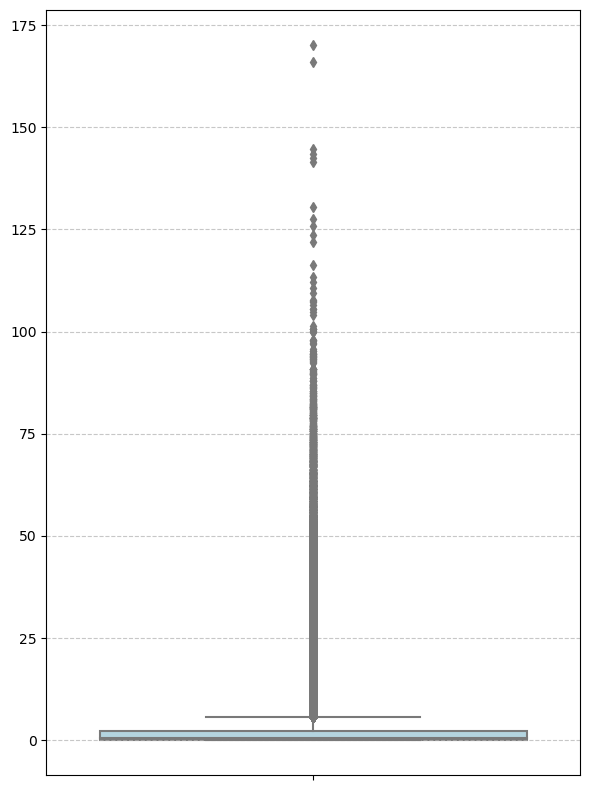

In [57]:
vertical_boxplot(testing,"","")

In [31]:
testing.describe(percentiles=[0.25, 0.5, 0.75, 0.90])

count    964395.000000
mean          1.854237
std           4.166261
min           0.000000
25%           0.000000
50%           0.581978
75%           2.315275
90%           4.503693
max         170.183026
Name: label, dtype: float64

In [38]:
values_above_p90 = testing[testing > testing.quantile(0.95)]
values_under_p90 = testing[testing < testing.quantile(0.95)]

In [46]:
len(values_under_p90)

916175

In [39]:
values_under_p90.describe()

count    916175.000000
mean          1.198444
std           1.550221
min           0.000000
25%           0.000000
50%           0.465627
75%           2.000262
max           6.745660
Name: label, dtype: float64

In [40]:
df_test = df[df["dataset"]=="MSV000080274"]

In [41]:
len(df_test)

1318265

In [47]:
new_df = df[df['modified_sequence'].isin(values_under_p90.index)]

In [58]:
df_test = new_df[new_df["dataset"]=="MSV000080274"]

In [59]:
testing2 = df_test.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

In [60]:
testing2.describe()

count    117828.000000
mean          2.616994
std           3.695032
min           0.000000
25%           0.000000
50%           1.228453
75%           3.876324
max          63.600572
Name: label, dtype: float64

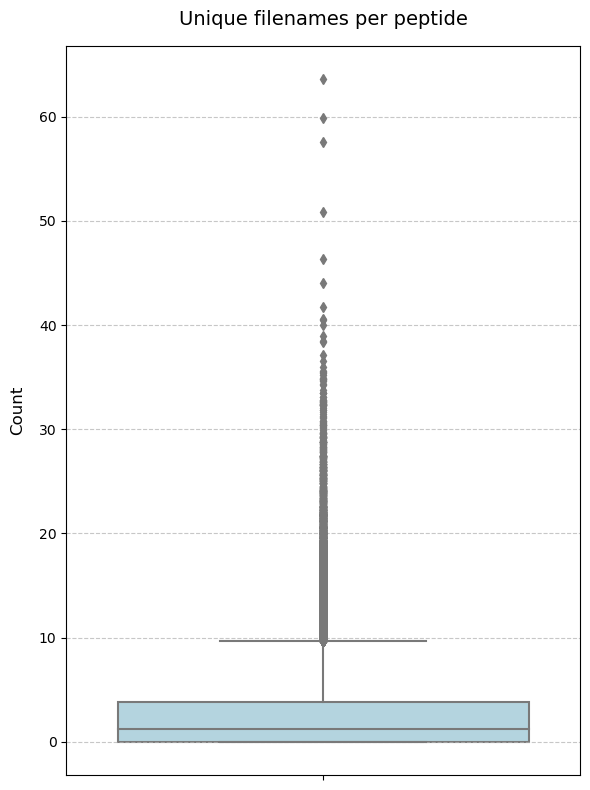

In [61]:
vertical_boxplot(testing2,"Count","Unique filenames per peptide")

# Different attempt

In [11]:
df =pd.read_parquet(DATASET)

In [20]:
datasets = df['dataset'].unique()

In [21]:
datasets

array(['MSV000080692', 'MSV000080744', 'MSV000080255', 'MSV000080757',
       'MSV000081649', 'MSV000080703', 'MSV000080254', 'MSV000080836',
       'MSV000079830', 'MSV000080873', 'MSV000080075', 'MSV000080701',
       'MSV000080841', 'MSV000079514', 'MSV000080077', 'MSV000079014',
       'MSV000080791', 'MSV000080813', 'MSV000080274', 'MSV000080834',
       'MSV000080643', 'MSV000080795', 'MSV000080225', 'MSV000079942',
       'MSV000080769', 'MSV000079943', 'MSV000079969', 'MSV000080774',
       'MSV000080762', 'MSV000080730', 'MSV000079550', 'MSV000080826',
       'MSV000078831', 'MSV000079841', 'MSV000080773', 'MSV000080843',
       'MSV000080688', 'MSV000080810', 'MSV000080849', 'MSV000079958',
       'MSV000080268', 'MSV000079644', 'MSV000080846', 'MSV000080076',
       'MSV000080845', 'MSV000080276', 'MSV000079944', 'MSV000079970',
       'MSV000080085', 'MSV000079971', 'MSV000080865', 'MSV000080088',
       'MSV000080226', 'MSV000080063', 'MSV000079539', 'MSV000080844',
      

In [22]:
from joblib import Parallel, delayed
from tqdm import tqdm

def process_dataset(dataset, df):
    print(f"running for {dataset}")
    temp_df = df[df['dataset'] == dataset]
    mad = temp_df.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))
    values_under_p95 = mad[mad < mad.quantile(0.95)]
    temp_df = temp_df[temp_df['modified_sequence'].isin(values_under_p95.index)]
    return temp_df

# Run in parallel with progress bar
dfs = Parallel(n_jobs=10)(
    delayed(process_dataset)(dataset, df) 
    for dataset in tqdm(datasets, desc="Processing datasets")
)


Processing datasets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [08:25<00:00,  8.15s/it]


In [23]:
big  = pd.concat(dfs, ignore_index=True)

In [25]:
testing = big.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

In [26]:
testing.describe()

count    954791.000000
mean          1.673386
std           3.942696
min           0.000000
25%           0.000000
50%           0.523809
75%           2.130703
max         170.183026
Name: label, dtype: float64

In [28]:
df_test = big[big["dataset"]=="MSV000080274"]
testing2 = df_test.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

In [29]:
testing2.describe()

count    121944.000000
mean          2.149964
std           2.600202
min           0.000000
25%           0.000000
50%           1.081087
75%           3.599833
max          10.272665
Name: label, dtype: float64

In [32]:
df_test = df[df["dataset"]=="MSV000080274"]
testing3 = df_test.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

In [33]:
testing3.describe()

count    128363.000000
mean          2.781289
std           3.909067
min           0.000000
25%           0.000000
50%           1.304733
75%           4.141786
max          76.970037
Name: label, dtype: float64

In [34]:
testing_big_2=big.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

In [35]:
values_under_p90 = testing_big_2[testing_big_2 < testing_big_2.quantile(0.95)]

In [36]:
big_better = big[big['modified_sequence'].isin(values_under_p90.index)]

In [38]:
big_better_testing=big_better.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x))

In [39]:
big_better_testing.describe()

count    907051.000000
mean          1.076688
std           1.375908
min           0.000000
25%           0.000000
50%           0.415651
75%           1.841773
max           5.815608
Name: label, dtype: float64